In [1]:
import dataset
from tensorflow import estimator as tf_estimator
import models.losses as losses
import tensorflow as tf
from models.metrics import *
import models.cnn_autoencoder_model as cnnmodel
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
hparams = {
    # 数据路径
    'train_path': '../dataset/next_day_wildfire_spread_train*',
    'eval_path': '../dataset/next_day_wildfire_spread_eval*',
    'test_path': '../dataset/next_day_wildfire_spread_test*',
    
    # 特征
    'input_features': ['elevation', 'pdsi', 'NDVI', 'pr', 'sph', 'th', 'tmmn',
                  'tmmx', 'vs', 'erc', 'population', 'PrevFireMask'],
    'output_features': ['FireMask'],
    
    # 方位通道
    'azimuth_in_channel': None,
    'azimuth_out_channel': None,
    
    # 数据和模型参数
    'data_sample_size': 64,
    'sample_size': 32,
    'output_sample_size': 32,
    'batch_size': 128,
    'shuffle': False,
    'shuffle_buffer_size': 10000,
    'compression_type': None,
    'input_sequence_length': 1,
    'output_sequence_length': 1,
    'repeat': False,
    'clip_and_normalize': True,
    'clip_and_rescale': False,
    
    # 数据增强
    'random_flip': False,
    'random_rotate': False,
    'random_crop': False,
    'center_crop': True,
    
    # 其他参数
    'downsample_threshold': 0.0,
    'binarize_output': True
}

train_dataset = dataset.make_dataset(
    hparams,
    mode = tf_estimator.ModeKeys.TRAIN
)
val_dataset = dataset.make_dataset(
    hparams,
    mode = tf_estimator.ModeKeys.EVAL
)
test_dataset = dataset.make_dataset(
    hparams,
    mode = tf_estimator.ModeKeys.PREDICT
)

In [4]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
)

## AutoEncoder

In [6]:
input_tensor = Input((32, 32, 12))
num_out_channels = 1
encoder_layers = [16,32]
decoder_layers = [32,16]
encoder_pools = [2,2]
decoder_pools = [2,2]
autoencoder_model = cnnmodel.create_model(
    input_tensor,
    num_out_channels,
    encoder_layers,
    decoder_layers,
    encoder_pools,
    decoder_pools,
)
autoencoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 12)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   1728        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 32, 16)   192         ['input_1[0][0]']            

In [7]:
optimizer = tf.keras.optimizers.Adam()
autoencoder_model.compile(optimizer=optimizer,
              loss=losses.weighted_cross_entropy_with_logits_with_masked_class(pos_weight=3),
              metrics=[AUCWithMaskedClass(with_logits=True)])
history = autoencoder_model.fit(train_dataset, epochs=1000, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/1000
118/118 [==============================] - 21s 35ms/step - loss: 0.2836 - auc_with_masked_class: 0.7639 - val_loss: 0.2968 - val_auc_with_masked_class: 0.8104
Epoch 2/1000
 35/118 [=======>......................] - ETA: 8s - loss: 0.2271 - auc_with_masked_class: 0.8596

KeyboardInterrupt: 

In [ ]:
autoencoder_model.evaluate(test_dataset)

14/14 [==============================] - 0s 25ms/step - loss: 0.2032 - auc_with_masked_class: 0.3595


[0.20317737758159637, 0.3595373034477234]

## U-Net

In [5]:
def expend_as(tensor, rep):
     return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def double_conv_layer(x, filter_size, size, dropout, batch_norm=False):
    axis = 3
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = Dropout(dropout)(conv)

    shortcut = Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = BatchNormalization(axis=axis)(shortcut)

    res_path = add([shortcut, conv])
    return res_path

def encoder(inputs):
    num_filters = [16, 32, 64, 128]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        a = double_conv_layer(x, 3, f, 0.1, True)
        skip_connections.append(a)
        x = MaxPooling2D(pool_size=(2, 2))(a)
    
    return x, skip_connections

def bottleneck(inputs):
    x = inputs
    f = 256
    
    x3 = double_conv_layer(x, 3, f, 0.1, True)
    
    return x3

def decoder(inputs, skip_connections):
    num_filters = [128, 64, 32, 16]
    skip_connections.reverse()
    x = inputs
    batch_norm = True
    
    for i, f in enumerate(num_filters):
        
        x_up = UpSampling2D(size=(2, 2), data_format="channels_last")(x)
        x_att = concatenate([x_up, skip_connections[i]], axis=-1)
        
        x = double_conv_layer(x_att, 3, f, 0.1, True)
    return x

def output(inputs):
    x = Conv2D(1, kernel_size=(1,1))(inputs)
    x = BatchNormalization()(x)
    # x = Activation('sigmoid')(x)
    
    return x

inputs = Input((32, 32, 12))
# s = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
s = inputs
x, skip_1 = encoder(s)
x = bottleneck(x)
x = decoder(x, skip_1)
outputs = output(x)
unet_model = Model(inputs, outputs)
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 12)  0           []                               
                                ]                                                                 
                                                                                                  
 separable_conv2d (SeparableCon  (None, 32, 32, 16)  316         ['input_1[0][0]']                
 v2D)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['separable_conv2d[0][0]']       
 alization)                                                                                   

In [6]:
optimizer = tf.keras.optimizers.Adam()
unet_model.compile(optimizer=optimizer,
              loss=losses.weighted_cross_entropy_with_logits_with_masked_class(pos_weight=3),
              metrics=[AUCWithMaskedClass(with_logits=True)])
history = unet_model.fit(train_dataset, epochs=1000, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/1000
118/118 [==============================] - 14s 49ms/step - loss: 0.6889 - auc_with_masked_class: 0.2693 - val_loss: 0.6338 - val_auc_with_masked_class: 0.1305
Epoch 2/1000
118/118 [==============================] - 12s 59ms/step - loss: 0.6119 - auc_with_masked_class: 0.3713 - val_loss: 0.5985 - val_auc_with_masked_class: 0.1514
Epoch 3/1000
118/118 [==============================] - 12s 59ms/step - loss: 0.5653 - auc_with_masked_class: 0.4030 - val_loss: 0.5465 - val_auc_with_masked_class: 0.1941
Epoch 4/1000
118/118 [==============================] - 12s 59ms/step - loss: 0.5249 - auc_with_masked_class: 0.4205 - val_loss: 0.5115 - val_auc_with_masked_class: 0.2805
Epoch 5/1000
118/118 [==============================] - 12s 60ms/step - loss: 0.4885 - auc_with_masked_class: 0.4402 - val_loss: 0.4897 - val_auc_with_masked_class: 0.3372
Epoch 6/1000
118/118 [==============================] - 12s 61ms/step - loss: 0.4564 - auc_with_masked_class: 0.4545 - val_loss: 0.4610 - va

In [7]:
unet_model.evaluate(test_dataset)

14/14 [==============================] - 1s 38ms/step - loss: 0.2233 - auc_with_masked_class: 0.3737


[0.22326718270778656, 0.3737252950668335]

In [45]:
from numba import cuda 
cuda.select_device(0) # eg.cuda.select_device(0)
cuda.close()

In [10]:
unet_model.save('saved_model/unet_model')

INFO:tensorflow:Assets written to: saved_model/unet_model\assets


INFO:tensorflow:Assets written to: saved_model/unet_model\assets


In [3]:
unet_model = tf.keras.models.load_model('saved_model/unet_model', custom_objects={
    'masked_weighted_cross_entropy_with_logits': losses.weighted_cross_entropy_with_logits_with_masked_class,
    'AUCWithMaskedClass': AUCWithMaskedClass(with_logits=True)
})

In [6]:
features = []
labels = []
for feature, label in test_dataset:
    features.append(feature.numpy())
    labels.append(label.numpy())
all_features = tf.concat(features, axis=0)
all_labels = tf.concat(labels, axis=0)

logits = unet_model.predict(all_features)
y_pred = tf.math.sigmoid(logits)
#mask = tf.cast(tf.not_equal(all_labels, -1), tf.float32)
predictions = tf.cast(y_pred >= 0.5, 'int32')

53/53 [==============================] - 3s 6ms/step


## Plotting

In [7]:
from matplotlib import colors
import matplotlib.pyplot as plt

TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask',
  'Predict\nmask',
]
# Number of rows of data samples to plot
n_rows = 10 
# Number of data variables
n_features = 12
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

In [8]:
inputs, labels = next(iter(test_dataset))

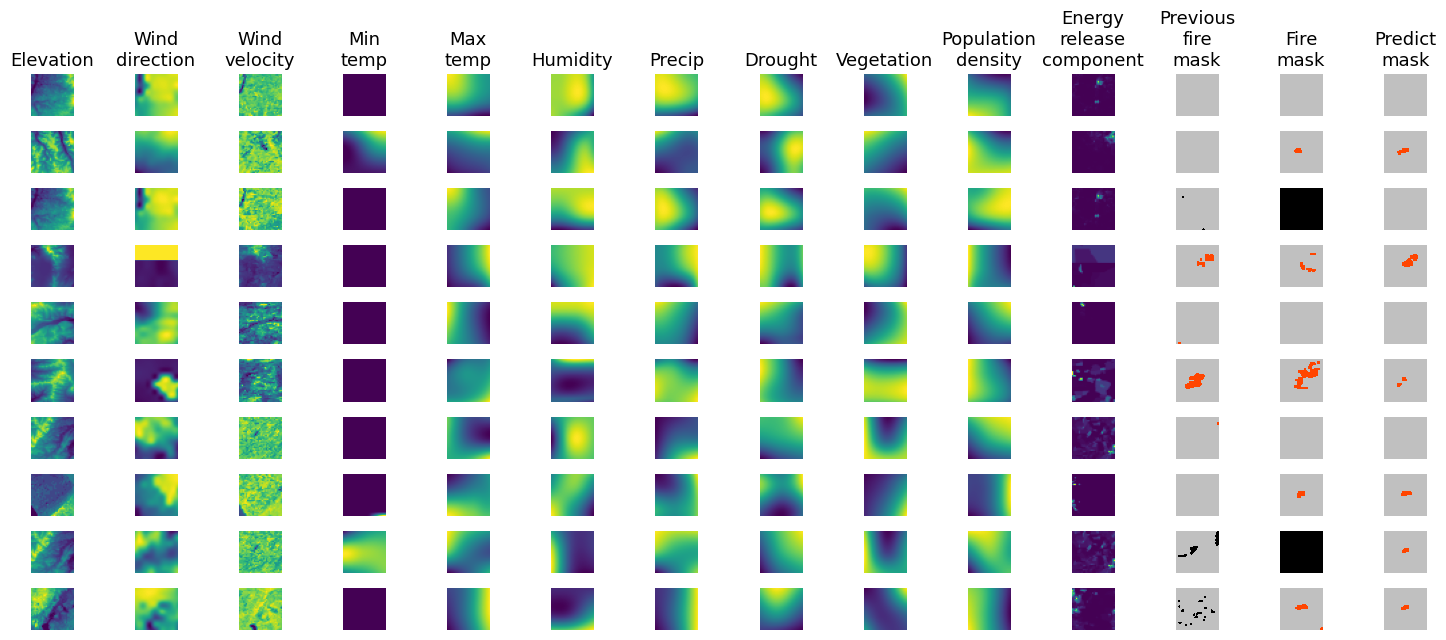

In [9]:
fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
  for j in range(n_features + 2):
    plt.subplot(n_rows, n_features + 2, i * (n_features + 2) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j < n_features - 1:
      plt.imshow(inputs[i, :, :, j], cmap='viridis')
    if j == n_features - 1:
      plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
    if j == n_features:
      plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM)
    if j == n_features + 1:
       plt.imshow(predictions[i, :, :, 0], cmap=CMAP, norm=NORM)
    plt.axis('off')
plt.tight_layout()

In [10]:
#from seggradcam.training_write import TrainingParameters, TrainingResults
#from seggradcam.training_plots import plot_predict_and_gt, plot_loss, plot_metric
from seggradcam.seggradcam import SegGradCAM, SuperRoI, ClassRoI, PixelRoI, BiasRoI
from seggradcam.visualize_sgc import SegGradCAMplot

In [11]:
cls = 0
image =  inputs[1]
prop_from_layer = unet_model.layers[-1].name
prop_to_layer = 'conv2d_9'

In [12]:
# create a SegGradCAM object
roi=PixelRoI(0,0,image)
pixsgc = SegGradCAM(unet_model, image, cls,  prop_to_layer,prop_from_layer, roi=roi,
                 normalize=True, abs_w=False, posit_w=False)
# compute SegGradCAM
pixsgc.SGC()
# create an object with plotting functionality
plotter = SegGradCAMplot(pixsgc,model=model,n_classes=n_classes,outfolder=mdir, gt = valset.Y[imid])
# plot explanations on 1 picture
plotter.explainPixel()

AttributeError: 'KerasTensor' object has no attribute '_id'